<div class="clearfix">
<img src="resources/softbutterfly.png" class="pull-left">
<img src="resources/jupyter.png" class="pull-right">
</div>

# Predicción del Ciclo Solar - El algoritmo McNish-Lincoln

**Martín Josemaría Vuelta Rojas**

martin.vuelta@softbutterfly.io

*Universidad Nacional Mayor de San Marcos*

Facultad de Ciencias Físicas

*SoftButterfly*<br>

Cofundador y CTO

## Ajustes gráficos e importación de librerias globales

In [1]:
%matplotlib inline

In [2]:
# Librerias que se utulizarán a lo largo de todo el notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uncertainties as unc
import uncertainties.unumpy as unp
import matplotlib.colors as pltc

In [3]:
# Ajustes generales para los gráficos
from distutils.spawn import find_executable
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn
import gc

plt.ioff()

plt.rc('lines', linewidth=1)
plt.rc('font', family='serif')

if find_executable('latex'):
    plt.rc('text', usetex=True)

# Minor Third Type Scale
scale_factor = 1.2
base_font_size = 12

font_title = FontProperties(size=base_font_size*(scale_factor**2))
font_label = FontProperties(size=base_font_size*(scale_factor**1))
font_legend = FontProperties(size=base_font_size*(scale_factor**0))
font_ticks = FontProperties(size=base_font_size*(scale_factor**-1))

seaborn.set(context='notebook', style='darkgrid')

## Procesamiento de datos

### Descarga de datos

Los datos de machas solares pueden obtenerse desde la página web de [SILSO](http://www.sidc.be/silso) (Sunspot Index and Long-term Solar Observations).

**Enlaces útiles**
1. Directorio de datos: http://sidc.oma.be/silso/datafiles
2. Especificacion de formato: http://sidc.oma.be/silso/newdataset

In [4]:
import re
from urllib import request

# Set OFFLINE to False to get the mos recent data from SILSO
OFFLINE = False

# Offline data is stored in the data directory
OFFLINE_DATA_LOCATION = './data/data.txt'

# Online data is obtained from SILSO
ONLINE_DATA_LOCATION = "http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.txt"


if OFFLINE:
    req = open(OFFLINE_DATA_LOCATION)
    raw_text_data = req.read().strip('\n')
else:
    req = request.urlopen(ONLINE_DATA_LOCATION)
    raw_text_data = req.read().decode('utf-8').strip('\n')
    
    # Refresh offline data
    file_handler = open(OFFLINE_DATA_LOCATION, 'w')
    file_handler.write(raw_text_data)
    file_handler.close()

### Preprocesamiento de datos

Los datos obtenidos estan en formato de texto. Se tiene de convertir a los tipos de datos correspondientes segun la especificacion de formato dada [aquí](http://sidc.oma.be/silso/newdataset). Una vez convertidos en el formato adecuado, los datos seran ordenados en un dataset de Pandas.

In [5]:
from collections import OrderedDict

# Regex pattern to remove spurious multiple white space
WHITE_SPACE = re.compile(r' +')

# Column headers according to SILSO, except the 'Date' header which is an integrations of year, month and 
# day headers indicated by SILSO 
HEADERS = ['Date', 'Decimal Date', 'SN value', 'SN error', 'Observations', 'Flag']

# Util functions
def isflag(ch):
    """Checks if the given character is a flag mark"""
    return ch == '*'


def fmt_pairing(x):
    """Match data with the correct format function"""
    formatters = [pd.Timestamp, float, float, float, float, isflag]
    date = '-'.join(x[0:3])
    fractional_date = x[3]
    sn_value = x[4]
    sn_std = x[5]
    observers = x[6]
    flag_mark = x[-1]
    
    values = [date, fractional_date, sn_value, sn_std, observers, flag_mark]
    return list(
        zip(formatters, values))


def parse(x):
    """Parses data in x to the corrext python format"""
    return list(map(lambda y: y[0](y[1]), fmt_pairing(x)))


raw_data = WHITE_SPACE.sub(' ', raw_text_data)
raw_data = raw_data.split('\n')[:-1]
raw_data = map(lambda l: l.split(' '), raw_data)
raw_data = list(raw_data)
raw_data = list(zip(*map(parse, raw_data)))
raw_data = pd.DataFrame(OrderedDict(zip(HEADERS, raw_data))).replace(-1.0, np.nan)
raw_data = raw_data.set_index(["Date"], drop=True)
raw_data

,Decimal Date,SN value,SN error,Observations,Flag
Date,,,,,
1818-01-01,1818.001,NaN,NaN,0.0,False
1818-01-02,1818.004,NaN,NaN,0.0,False
1818-01-03,1818.007,NaN,NaN,0.0,False
1818-01-04,1818.010,NaN,NaN,0.0,False
1818-01-05,1818.012,NaN,NaN,0.0,False
1818-01-06,1818.015,NaN,NaN,0.0,False
1818-01-07,1818.018,NaN,NaN,0.0,False
1818-01-08,1818.021,65.0,10.2,1.0,False
1818-01-09,1818.023,NaN,NaN,0.0,False


#### Algundas cifras

Obtenemos tres cantidades: 
* El total de registros
* La cantidad de registros en los cuales no se registraron obserrvaciones, es decir, se tiene que el valor de 'SN value' es NaN o, de forma equivalente, 'Observations' es 0.
* El total de dias que no se observaron manchas en el disco solar, es decir, que el valor de 'SN value' fue igual a 0.

In [6]:
# Basic Stats
# Missing data (SN values = nan or Observations = 0)
missing_data = len(raw_data.values[raw_data['Observations'].values == 0])

# Days without sunspots (SN values = 0)
no_sunspot_days = len(raw_data.values[raw_data['SN value'].values == 0])

print(f"Total de registros    : {len(raw_data)} ")
print(f"Días sin observaciones: {missing_data}")
print(f"Días sin manchas      : {no_sunspot_days}")

Total de registros    : 73382 
Días sin observaciones: 3247
Días sin manchas      : 10857


### Registros diarios

Los datos que nos interesan del dataset anterior son "SN value" y "SN error" po lo cual seran separados en un dataset aparte.

In [7]:
sn_daily = raw_data.drop(['Decimal Date', 'Observations', 'Flag'], 1)
sn_daily.insert(0, 'SN', unp.uarray(sn_daily['SN value'].values, sn_daily['SN error'].values))
sn_daily

,SN,SN value,SN error
Date,,,
1818-01-01,nan+/-nan,NaN,NaN
1818-01-02,nan+/-nan,NaN,NaN
1818-01-03,nan+/-nan,NaN,NaN
1818-01-04,nan+/-nan,NaN,NaN
1818-01-05,nan+/-nan,NaN,NaN
1818-01-06,nan+/-nan,NaN,NaN
1818-01-07,nan+/-nan,NaN,NaN
1818-01-08,65+/-10,65.0,10.2
1818-01-09,nan+/-nan,NaN,NaN


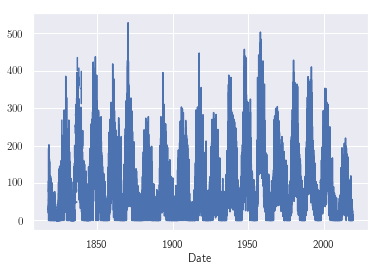

In [8]:
# Sample plot for daily records
sn_daily['SN value'].plot(color='b')
plt.show()

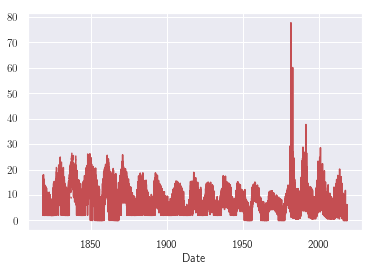

In [9]:
# Sample plot for daily records error
sn_daily['SN error'].plot(color='r')
plt.show()

#### Gráfico de registros diarios

Realizaremos un grafico más detallado de los datos dividiéndolos en el punto en que se registra el último día con datos perdidos (Sin observaciones). 

Los gráficos diarios se realizan en periodos de 50 años empezando desde 1818, el primer año de los registros obtenidos desde [SILSO](http://www.sidc.be/silso)

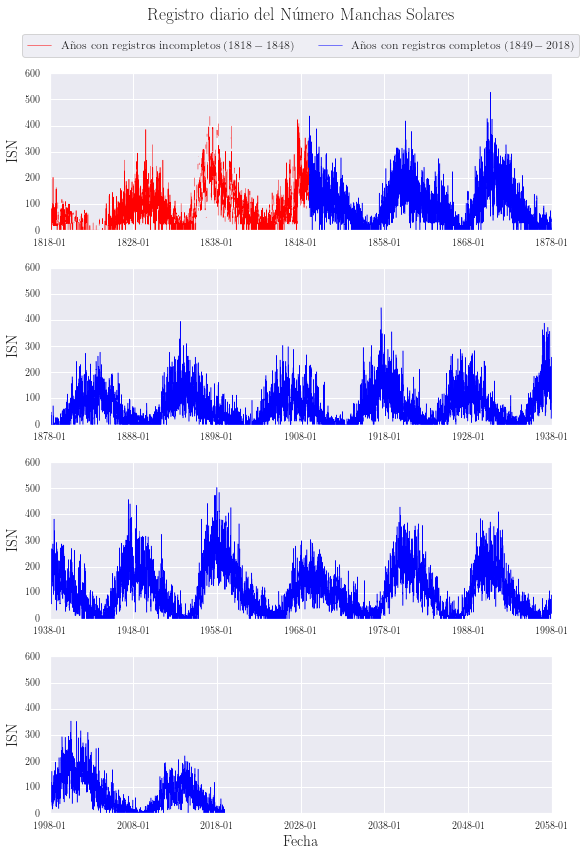

In [10]:
YEAR_DELTA = 60
X_TICKS_DELTA = 10

periods = int(np.ceil((sn_daily.index[-1].year - sn_daily.index[0].year) / YEAR_DELTA))

fig = plt.figure(figsize=(8.5, periods * 3), frameon=False, facecolor="#ffffff")
title = r"$\mathrm{Registro\ diario\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = np.ceil(sn_daily['SN value'].max() / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

last_nan_index = np.where(np.isnan(sn_daily['SN value']))[0][-1] + 1
last_nan_date = sn_daily.index[last_nan_index]

first_axs = None

for i in range(periods):
    axs = fig.add_subplot(periods, 1, i + 1)
    
    if i == 0:
        first_axs = axs
        
    x_liml = pd.Timestamp(sn_daily.index[0].year + i * YEAR_DELTA, 1, 1)
    x_limu = pd.Timestamp(sn_daily.index[0].year + (i + 1) * YEAR_DELTA - 1, 12, 31)

    data = sn_daily[x_liml:x_limu]

    if x_limu <= last_nan_date:
        axs.plot(
            data['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
    elif x_liml <= last_nan_date and last_nan_date <= x_limu:
        graph1, = axs.plot(
            data[:last_nan_date]['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
        graph2, = axs.plot(
            data[last_nan_date:]['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)
        
    else:
        axs.plot(
            data['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(YEAR_DELTA / X_TICKS_DELTA)
    d_xticks = np.ceil((x_limu.year - (x_liml + pd.Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [pd.Timestamp(int(x_liml.year + i * d_xticks), 1, 1) for i in range(n_xticks + 1)]
    l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

    axs.set_xlim([x_liml, x_limu + pd.Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

first_axs.set_title(title, fontproperties=font_title)
first_axs.title.set_position([.5, 1.30])  
first_axs.legend(
    (graph1, graph2),
    (
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ incompletos\ }$" +
            r"$({0:}-{1:})$".format(
                sn_daily.index[0].year,
                sn_daily[:last_nan_date].index[-1].year)
        ),
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ completos\ }$" + 
            r"$({0:}-{1:})$".format(
                sn_daily[last_nan_date:].index[0].year + 1,
                sn_daily.index[-1].year)
        )
    ),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)

fig.tight_layout()
plt.show()

### Promedios mensuales

Los datos diarios, como serie de tiempo, contienen una gran cantidad de ruido y varios periodos de datos perdidos. Para poder trabajarlos de mejor forma reducimos el ruido tomando el promedio mensual.

In [11]:
def umean(x):
    test = [measure.nominal_value for measure in x]
    if all(np.isnan(test)):
        return unc.ufloat(np.nan, np.nan)
    
    if any(np.isnan(test)):
        return np.nanmean(x)
    
    return np.mean(x)

In [12]:
# The trick to calculate the resultin amount of data is count all
# the first day of each month in every year
ndata = len(sn_daily.index[sn_daily.index.day == 1])

years = set(sn_daily.index.year)
months = set(sn_daily.index.month)

sn = np.empty([ndata, 4], dtype='object')
index = 0

for year in years:
    year_group = sn_daily[sn_daily.index.year == year]
    for month in months:
        month_group = year_group[year_group.index.month == month]
        
        if len(month_group) == 0:
            break

        sn_mean = umean(month_group['SN'].values)
        sn[index] = [pd.Timestamp(f'{year}-{month}-01'), sn_mean, sn_mean.nominal_value, sn_mean.std_dev]
        index += 1
        
    if len(month_group) == 0:
        break

sn = list(zip(*sn))
sn = dict(zip(['Date', 'SN', 'SN value', 'SN error'], sn))
sn_monthly = pd.DataFrame(sn)
sn_monthly = sn_monthly.set_index(["Date"], drop=True)
sn_monthly

,SN,SN value,SN error
Date,,,
1818-01-01,58.1+/-3.4,58.125000,3.417144
1818-02-01,37.4+/-2.1,37.428571,2.094940
1818-03-01,42.4+/-2.2,42.357143,2.210284
1818-04-01,57.5+/-2.1,57.523810,2.093565
1818-05-01,88.5+/-2.4,88.480000,2.383312
1818-06-01,60.8+/-2.0,60.800000,1.975903
1818-07-01,46.8+/-1.9,46.761905,1.888844
1818-08-01,52.5+/-2.1,52.550000,2.053168
1818-09-01,43.4+/-2.0,43.388889,1.966345


#### Explorando data perdida en los promedios mensuales

In [13]:
sn_monthly[np.isnan(sn_monthly['SN value'])]

,SN,SN value,SN error
Date,,,
1824-02-01,nan+/-nan,NaN,NaN


Hay un solo mes que tiene como promedio *NaN*, esto se debe a que en dicho mes no hubo ninguna observación registrada, como comprobaremos a continuación con los datos diarios.

In [14]:
# Obtenemos la fecha en la cual no se registraron datos
missing_data_date = sn_monthly[np.isnan(sn_monthly['SN value'])].index

# Obtenemos todos los datos con el mismo año que la fecha obtenida en missing_data_date
missing_data = sn_daily[sn_daily.index.year == np.full(len(sn_daily), missing_data_date.year)]

# Con los resultados obtenidos obtenemos todos aquellos que corresponden al mes en missing_data_date
missing_data = missing_data[missing_data.index.month == np.full(len(missing_data), missing_data_date.month)]
missing_data

,SN,SN value,SN error
Date,,,
1824-02-01,nan+/-nan,NaN,NaN
1824-02-02,nan+/-nan,NaN,NaN
1824-02-03,nan+/-nan,NaN,NaN
1824-02-04,nan+/-nan,NaN,NaN
1824-02-05,nan+/-nan,NaN,NaN
1824-02-06,nan+/-nan,NaN,NaN
1824-02-07,nan+/-nan,NaN,NaN
1824-02-08,nan+/-nan,NaN,NaN
1824-02-09,nan+/-nan,NaN,NaN


#### Gráfico de promedios mensuales

##### **Promedios mensuales**

De igual forma que se realizo el grafico de registros diarios, se muestra el gráfico de los promedios mensuales

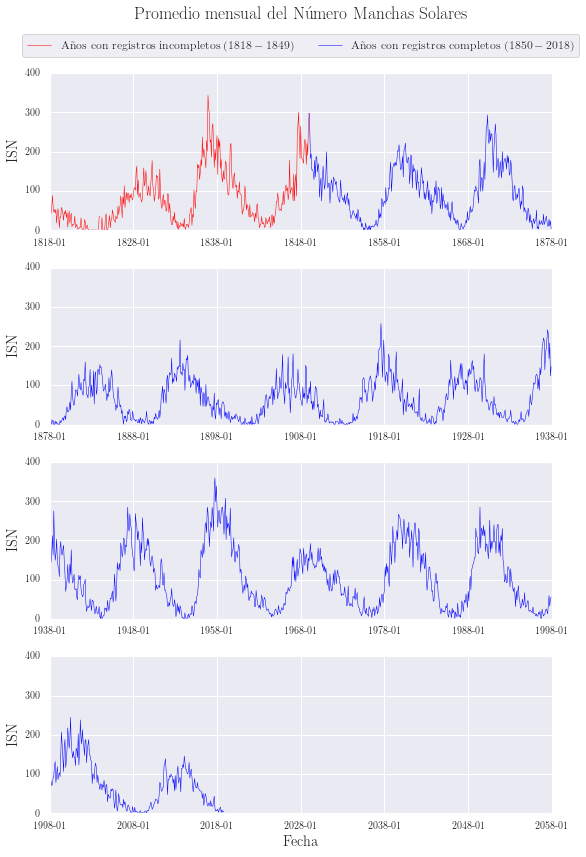

In [15]:
YEAR_DELTA = 60
X_TICKS_DELTA = 10

periods = int(np.ceil((sn_monthly.index[-1].year - sn_monthly.index[0].year) / YEAR_DELTA))

fig = plt.figure(figsize=(8.5, periods * 3), frameon=False, facecolor="#ffffff")
title = r"$\mathrm{Promedio\ mensual\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = np.ceil(sn_monthly['SN value'].max() / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

last_nan_index = np.where(np.isnan(sn_daily['SN value']))[0][-1] + 1
last_nan_date = sn_daily.index[last_nan_index]
last_nan_date = sn_monthly[last_nan_date:].index[0]

first_axs = None

for i in range(periods):
    axs = fig.add_subplot(periods, 1, i + 1)
    
    if i == 0:
        first_axs = axs
        
    x_liml = pd.Timestamp(sn_monthly.index[0].year + i * YEAR_DELTA, 1, 1)
    x_limu = pd.Timestamp(sn_monthly.index[0].year + (i + 1) * YEAR_DELTA - 1, 12, 31)

    data = sn_monthly[x_liml:x_limu]

    if x_limu <= last_nan_date:
        axs.plot(
            data['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
    elif x_liml <= last_nan_date and last_nan_date <= x_limu:
        graph1, = axs.plot(
            data[:last_nan_date]['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
        graph2, = axs.plot(
            data[last_nan_date:]['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)
        
    else:
        axs.plot(
            data['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(YEAR_DELTA / X_TICKS_DELTA)
    d_xticks = np.ceil((x_limu.year - (x_liml + pd.Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [pd.Timestamp(int(x_liml.year + i * d_xticks), 1, 1) for i in range(n_xticks + 1)]
    l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

    axs.set_xlim([x_liml, x_limu + pd.Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

first_axs.set_title(title, fontproperties=font_title)
first_axs.title.set_position([.5, 1.30])  
first_axs.legend(
    (graph1, graph2),
    (
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ incompletos\ }$" +
            r"$({0:}-{1:})$".format(
                sn_monthly.index[0].year,
                sn_monthly[:last_nan_date].index[-1].year)
        ),
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ completos\ }$" + 
            r"$({0:}-{1:})$".format(
                sn_monthly[last_nan_date:].index[0].year + 1,
                sn_monthly.index[-1].year)
        )
    ),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    # bbox_to_anchor=(0.5, 1-SPACING_ADJUST),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)

fig.tight_layout()
plt.show()

##### **Superposición del promedio mensual sobre el registro diario**

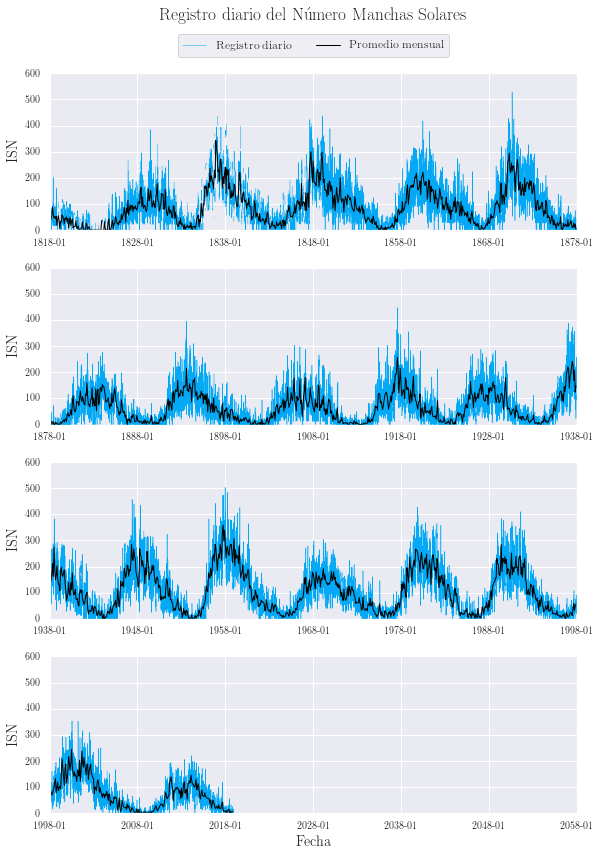

In [16]:
YEAR_DELTA = 60
X_TICKS_DELTA = 10
SPACING_ADJUST = 0.025

periods = int(np.ceil((sn_monthly.index[-1].year - sn_monthly.index[0].year) / YEAR_DELTA))

fig = plt.figure(figsize=(8.5, periods * 3), frameon=False, facecolor="#ffffff")
title = r"$\mathrm{Registro\ diario\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = np.ceil(sn_daily['SN value'].max() / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot(periods, 1, i + 1)    
        
    x_liml = pd.Timestamp(sn_monthly.index[0].year + i * YEAR_DELTA, 1, 1)
    x_limu = pd.Timestamp(sn_monthly.index[0].year + (i + 1) * YEAR_DELTA - 1, 12, 31)
    
    data = sn_daily[x_liml:x_limu]

    graph1, = axs.plot(
        data['SN value'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True)
    
    data = sn_monthly[x_liml:x_limu]

    graph2, = axs.plot(
        data['SN value'],
        color='black',
        linewidth=1.0,
        antialiased=True)
        
    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.30])  
        axs.legend(
            (graph1, graph2),
            (
                r"$\mathrm{Registro\ diario}$",
                r"$\mathrm{Promedio\ mensual}$"
            ),
            loc='upper center',
            bbox_to_anchor=(0.5, 1.25),
            ncol=2,
            borderaxespad=0.0,
            prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(YEAR_DELTA / X_TICKS_DELTA)
    d_xticks = np.ceil((x_limu.year - (x_liml + pd.Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [pd.Timestamp(int(x_liml.year + i * d_xticks), 1, 1) for i in range(n_xticks + 1)]
    l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

    axs.set_xlim([x_liml, x_limu + pd.Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    # axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

fig.tight_layout()
plt.show()

### Media movil: Reducción de ruido

Aún el promedio mensual contiene una cantidad considerable de ruido: una alta variabilidad en valores contiguos. Este ruido se puede reducir aplicando una media movil. El ancho de la media movil según la literatura es de $13$ y con un pero unitario en los extremos y el doble en los valores centrales. La formula para calcular esta media movil es la siguiente

$$
\tilde{\mathcal{R}}_n = \frac{1}{24}\sum_{i=-6}^{5}\mathcal{R}_{n+i} + \frac{1}{24}\sum_{i=-5}^{6}\mathcal{R}_{n+i}
$$

Este filtro elimina buena parte del ruido y, aunque no es el mejor, es el mas ampliamente usado.

In [17]:
def uwmean(w, x):
    if len(w) != len(x):
        return unc.ufloat(np.nan, np.nan)
    
    test = [measure.nominal_value for measure in x]
    
    if all(np.isnan(test)):
        return unc.ufloat(np.nan, np.nan)
    
    if any(np.isnan(test)):
        return np.nansum(w * x)

    return np.sum(w * x)

In [18]:
ndata = len(sn_monthly)
sn = np.empty([ndata, 4], dtype='object')

w = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
w = w/np.sum(w)

for index in range(ndata):
    ilower = index - 6
    ilower = ilower if ilower >= 0 else 0

    iupper = index + 7
    iupper = iupper if iupper < ndata else ndata

    group = sn_monthly[ilower:iupper]

    sn_wmean = uwmean(w, group['SN'].values)
    sn[index] = [sn_monthly.index[index], sn_wmean, sn_wmean.nominal_value, sn_wmean.std_dev]

sn = list(zip(*sn))
sn = dict(zip(['Date', 'SN', 'SN value', 'SN error'], sn))
sn_smooth = pd.DataFrame(sn)
sn_smooth = sn_smooth.set_index(["Date"], drop=True)
sn_smooth

,SN,SN value,SN error
Date,,,
1818-01-01,nan+/-nan,NaN,NaN
1818-02-01,nan+/-nan,NaN,NaN
1818-03-01,nan+/-nan,NaN,NaN
1818-04-01,nan+/-nan,NaN,NaN
1818-05-01,nan+/-nan,NaN,NaN
1818-06-01,nan+/-nan,NaN,NaN
1818-07-01,50.0+/-0.6,49.982684,0.597472
1818-08-01,49.7+/-0.6,49.720730,0.601471
1818-09-01,48.1+/-0.6,48.098861,0.599040


#### Explorando datos perdidos en los promedios suavizados

El filtro aplicado es solo valido para los datos centrales de la serie de tiempo, perdiendo los $6$ primeros y los $6$ últimos valores de la serie.

In [19]:
len(sn_smooth[np.isnan(sn_smooth['SN value'])])

12

In [20]:
sn_smooth[np.isnan(sn_smooth['SN value'])]

,SN,SN value,SN error
Date,,,
1818-01-01,nan+/-nan,NaN,NaN
1818-02-01,nan+/-nan,NaN,NaN
1818-03-01,nan+/-nan,NaN,NaN
1818-04-01,nan+/-nan,NaN,NaN
1818-05-01,nan+/-nan,NaN,NaN
1818-06-01,nan+/-nan,NaN,NaN
2018-06-01,nan+/-nan,NaN,NaN
2018-07-01,nan+/-nan,NaN,NaN
2018-08-01,nan+/-nan,NaN,NaN


In [21]:
sn_smooth[np.isnan(sn_smooth['SN value'])][:6]

,SN,SN value,SN error
Date,,,
1818-01-01,nan+/-nan,NaN,NaN
1818-02-01,nan+/-nan,NaN,NaN
1818-03-01,nan+/-nan,NaN,NaN
1818-04-01,nan+/-nan,NaN,NaN
1818-05-01,nan+/-nan,NaN,NaN
1818-06-01,nan+/-nan,NaN,NaN


In [22]:
sn_smooth[np.isnan(sn_smooth['SN value'])][-6:]

,SN,SN value,SN error
Date,,,
2018-06-01,nan+/-nan,NaN,NaN
2018-07-01,nan+/-nan,NaN,NaN
2018-08-01,nan+/-nan,NaN,NaN
2018-09-01,nan+/-nan,NaN,NaN
2018-10-01,nan+/-nan,NaN,NaN
2018-11-01,nan+/-nan,NaN,NaN


Habiendo identificado que los valores `NaN` los eliminamos del conjunto principal de datos.

In [23]:
sn_smooth = sn_smooth[6:-6]
sn_smooth

,SN,SN value,SN error
Date,,,
1818-07-01,50.0+/-0.6,49.982684,0.597472
1818-08-01,49.7+/-0.6,49.720730,0.601471
1818-09-01,48.1+/-0.6,48.098861,0.599040
1818-10-01,45.6+/-0.6,45.603822,0.578456
1818-11-01,42.3+/-0.6,42.284998,0.559415
1818-12-01,39.9+/-0.5,39.851405,0.546668
1819-01-01,40.0+/-0.6,39.983306,0.551675
1819-02-01,39.8+/-0.6,39.842185,0.557115
1819-03-01,38.7+/-0.5,38.689446,0.548512


#### Gráfico de promedios sauvizados

##### **Promedio suavizados**

De igual forma que se realizo el grafico de promedios mensuales, se muestra el gráfico de los promedios suavizados

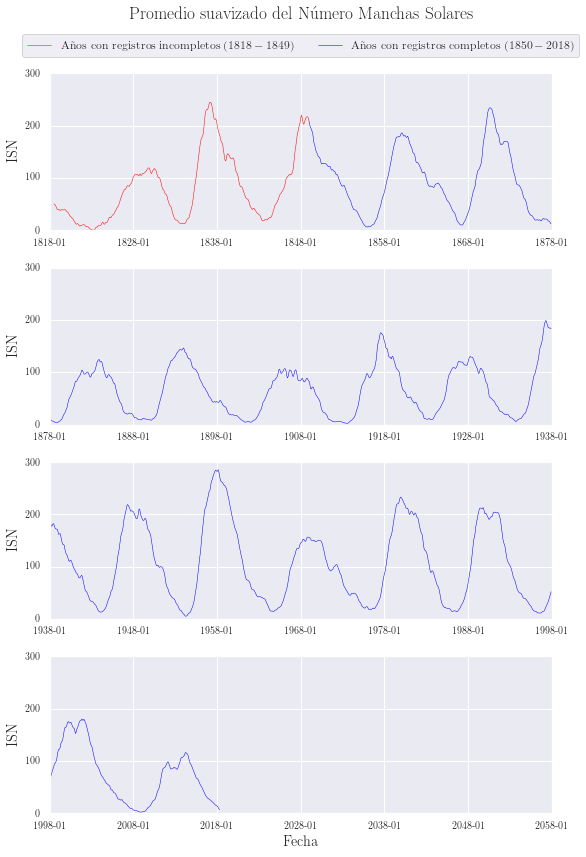

In [24]:
from pandas import Timedelta

YEAR_DELTA = 60
X_TICKS_DELTA = 10

periods = int(np.ceil((sn_smooth.index[-1].year - sn_smooth.index[0].year) / YEAR_DELTA))

fig = plt.figure(figsize=(8.5, periods * 3), frameon=False, facecolor="#ffffff")
title = r"$\mathrm{Promedio\ suavizado\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = np.ceil(sn_smooth['SN value'].max() / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

offset = 2
last_nan_index = np.where(np.isnan(sn_daily['SN value']))[0][-1] + offset
last_nan_date = sn_daily.index[last_nan_index]
last_nan_date = sn_smooth[last_nan_date:].index[0]

first_axs = None

for i in range(periods):
    axs = fig.add_subplot(periods, 1, i + 1)
    
    if i == 0:
        first_axs = axs
        
    x_liml = pd.Timestamp(sn_smooth.index[0].year + i * YEAR_DELTA, 1, 1)
    x_limu = pd.Timestamp(sn_smooth.index[0].year + (i + 1) * YEAR_DELTA - 1, 12, 31)

    data = sn_smooth[x_liml:x_limu]

    if x_limu <= last_nan_date:
        axs.plot(
            data['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
    elif x_liml <= last_nan_date and last_nan_date <= x_limu:
        graph1, = axs.plot(
            data[:last_nan_date]['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True)
        
        graph2, = axs.plot(
            data[last_nan_date:]['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)
        
    else:
        axs.plot(
            data['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(YEAR_DELTA / X_TICKS_DELTA)
    d_xticks = np.ceil((x_limu.year - (x_liml + pd.Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [pd.Timestamp(int(x_liml.year + i * d_xticks), 1, 1) for i in range(n_xticks + 1)]
    l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

    axs.set_xlim([x_liml, x_limu + pd.Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

first_axs.set_title(title, fontproperties=font_title)
first_axs.title.set_position([.5, 1.30])  
first_axs.legend(
    (graph1, graph2),
    (
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ incompletos\ }$" +
            r"$({0:}-{1:})$".format(
                sn_smooth.index[0].year,
                sn_smooth[:last_nan_date].index[-1].year)
        ),
        (
            r"$\mathrm{A\tilde{n}os\ con\ }$" +
            r"$\mathrm{registros\ completos\ }$" + 
            r"$({0:}-{1:})$".format(
                sn_smooth[last_nan_date:].index[0].year + 1,
                sn_smooth.index[-1].year)
        )
    ),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)

fig.tight_layout()
plt.show()

##### **Superposición del promedio sauvizado sobre el promedio mensual**

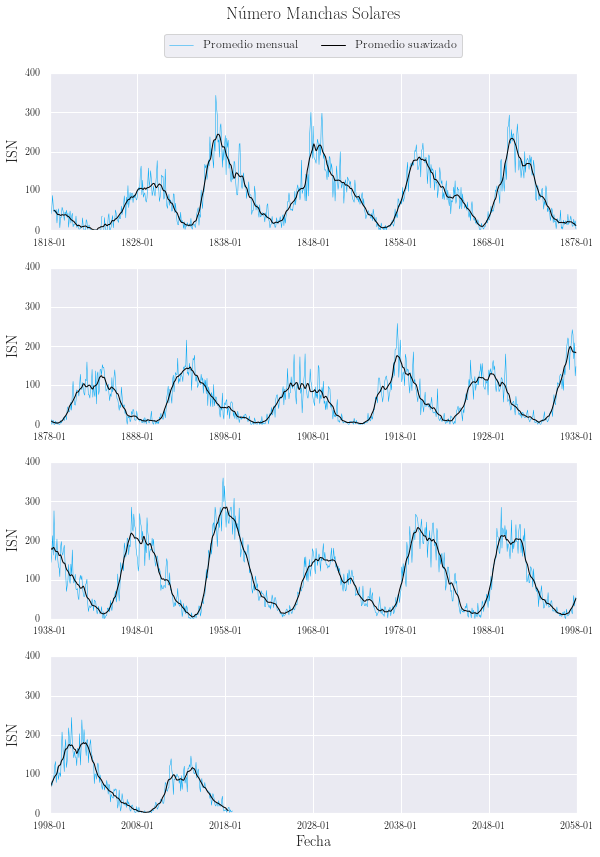

In [25]:
from pandas import Timedelta

YEAR_DELTA = 60
X_TICKS_DELTA = 10
SPACING_ADJUST = 0.025

periods = int(np.ceil((sn_smooth.index[-1].year - sn_smooth.index[0].year) / YEAR_DELTA))

fig = plt.figure(figsize=(8.5, periods * 3), frameon=False, facecolor="#ffffff")
title = r"$\mathrm{N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = np.ceil(sn_monthly['SN value'].max() / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot(periods, 1, i + 1)    
        
    x_liml = pd.Timestamp(sn_smooth.index[0].year + i * YEAR_DELTA, 1, 1)
    x_limu = pd.Timestamp(sn_smooth.index[0].year + (i + 1) * YEAR_DELTA - 1, 12, 31)
    
    data = sn_monthly[x_liml:x_limu]

    graph1, = axs.plot(
        data['SN value'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True)
    
    data = sn_smooth[x_liml:x_limu]

    graph2, = axs.plot(
        data['SN value'],
        color='black',
        linewidth=1.0,
        antialiased=True)
        
    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.30])  
        axs.legend(
            (graph1, graph2),
            (
                r"$\mathrm{Promedio\ mensual}$",
                r"$\mathrm{Promedio\ suavizado}$"
            ),
            loc='upper center',
            bbox_to_anchor=(0.5, 1.25),
            ncol=2,
            borderaxespad=0.0,
            prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(YEAR_DELTA / X_TICKS_DELTA)
    d_xticks = np.ceil((x_limu.year - (x_liml + pd.Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [pd.Timestamp(int(x_liml.year + i * d_xticks), 1, 1) for i in range(n_xticks + 1)]
    l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

    axs.set_xlim([x_liml, x_limu + pd.Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    # axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

fig.tight_layout()
plt.show()

## Algoritmo de McNish-Lincoln

### Detección de picos

#### Algoritmo de detección

In [26]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    
    return x_axis, y_axis

In [27]:
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

#### Gráfico interactivo para la eliminación de falsos positivos

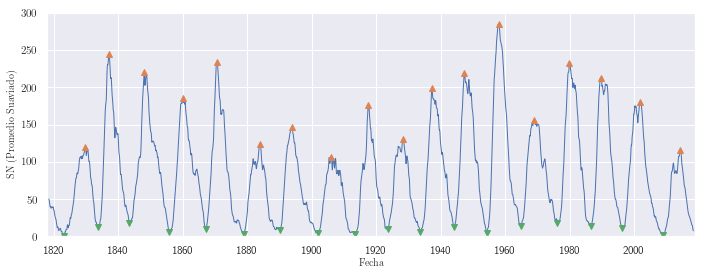

In [28]:
from IPython.display import display
from ipywidgets import *

w_lookahead = IntSlider(min=1, max=100, step=1, value=20)
wc_lookahead = VBox([Label(value='Lookahead'), w_lookahead])

w_delta = IntSlider(min=1, max=100, step=1, value=1)
wc_delta = VBox([Label(value='Delta'), w_delta])

wc_controllers = HBox([wc_lookahead, wc_delta])

w_maxima_label = Label(value="Máximos")
w_maxima_label.layout.width = '90%'

w_maxima_selector = SelectMultiple(options=[])

w_maxima_clean = Button(description='Limpiar seleción de máximos')
w_maxima_clean.layout.margin = '5px 2px 0'
w_maxima_clean.layout.width = '300px'

wc_maxima = VBox([w_maxima_label, w_maxima_selector, w_maxima_clean])

w_minima_label = Label(value="Mínimos")
w_minima_label.layout.width = '90%'

w_minima_selector = SelectMultiple(options=[])

w_minima_clean = Button(description='Limpiar seleción de mínimos')
w_minima_clean.layout.margin = '5px 2px 0'
w_minima_clean.layout.width = '300px'

wc_minima = VBox([w_minima_label, w_minima_selector, w_minima_clean])

wc_peaks = HBox([wc_maxima, wc_minima])

w_message = Label(value="Selecione los máximos y mínimos que desea eliminar.")
w_message.layout.margin = '5px 0'
w_message.layout.width = '600px'
w_message.layout.maxWidth = ''

wc_message = VBox([w_message])

w_output = Output()

wc_container = VBox([wc_controllers, wc_message, wc_peaks, w_output])

fig = None

def update_peaks(*args):
    maxima, minima = peakdetect(
        sn_smooth['SN value'].values,
        sn_smooth.index.values,
        lookahead=w_lookahead.value,
        delta=w_delta.value)

    wc_maxima.children[0].value = "Máximos ({0:})".format(len(maxima))
    wc_minima.children[0].value = "Mínimos ({0:})".format(len(minima))

    minima = [
        '{0:0>2d}: '.format(n + 1) + pd.Timestamp(d).strftime("%Y-%m") +
        ' ({0:.3f})'.format(v) for n, (d, v) in enumerate(minima)
    ]
    maxima = [
        '{0:0>2d}: '.format(n + 1) + pd.Timestamp(d).strftime("%Y-%m") +
        ' ({0:.3f})'.format(v) for n, (d, v) in enumerate(maxima)
    ]

    w_minima_selector.options = minima
    w_maxima_selector.options = maxima


def clean_peaks(*args):
    if args[0] == w_maxima_clean:
        w_maxima_selector.value = []

    elif args[0] == w_minima_clean:
        w_minima_selector.value = []

    else:
        pass

    
def plotter(*args):
    global fig
    
    maxima = list(
        zip(*map(lambda x: (x, sn_smooth['SN value'][x]),
                 map(lambda x: pd.Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_maxima_selector.value,
                                        w_maxima_selector.options))))))))

    minima = list(
        zip(*map(lambda x: (x, sn_smooth['SN value'][x]),
                 map(lambda x: pd.Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_minima_selector.value,
                                        w_minima_selector.options))))))))
    
    if fig is None:
        fig = plt.figure(figsize=(10, 4), frameon=False)
    else:
        fig.clf()
        
    axs = fig.add_subplot('111')

    gsn_smooth, = axs.plot(
        sn_smooth['SN value'],
        linewidth=1
    )

    gmaxima, = axs.plot(
        maxima[0],
        maxima[1],
        linewidth=0.0,
        marker='^', )

    gminima, = axs.plot(
        minima[0],
        minima[1],
        linewidth=0.0,
        marker='v', )

    axs.set_xlim([sn_daily.index[0], sn_daily.index[-1]])
    axs.set_xlabel(r'$\mathrm{Fecha}$', fontproperties=font_ticks)
    axs.set_ylim([0, np.ceil(np.nanmax(sn_smooth['SN value'].values)/100.0)*100])
    axs.set_ylabel(r'$\mathrm{SN\ (Promedio\ Suaviado)}$', fontproperties=font_ticks)
    fig.tight_layout()
    plt.show()

w_lookahead.observe(update_peaks, 'value')
w_lookahead.observe(plotter, 'value')

w_delta.observe(update_peaks, 'value')
w_delta.observe(plotter, 'value')

w_maxima_selector.observe(plotter, 'value')
w_maxima_clean.on_click(clean_peaks)

w_minima_selector.observe(plotter, 'value')
w_minima_clean.on_click(clean_peaks)

wc_container.on_displayed(update_peaks)
wc_container.on_displayed(plotter)

display(wc_container)

### Consturcción del ciclo promedio entre mínimos

#### División de ciclos entre mínimos

In [29]:
minima = list(
        zip(*map(lambda x: (x, sn_smooth['SN'][x]),
                 map(lambda x: pd.Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_minima_selector.value,
                                        w_minima_selector.options))))))))

maxima = list(
    zip(*map(lambda x: (x, sn_smooth['SN value'][x]),
             map(lambda x: pd.Timestamp(*x),
                 map(lambda x: list(map(int, x)) + [1],
                     map(lambda x: x[1].split('-'),
                         map(lambda x: x.split(' '),
                             filter(lambda x: x not in w_maxima_selector.value,
                                    w_maxima_selector.options))))))))

stops = [sn_smooth.index[0]] + list(minima[0])
lengths = np.diff(np.array(list(map(sn_smooth.index.get_loc, stops))))
maxlength = np.max(lengths)

headers = [[],[]]
lcycles = {}
dfcycles = np.empty((maxlength, 3*len(stops)), dtype='object')

for i in range(len(stops)):
    h = "Cycle {0:>2d}".format(i+6)
    
    c = sn_smooth.copy()
    
    if i == len(stops) - 1:
        c = c[stops[i]:]
    else:
        c = c[stops[i]:stops[i+1]-pd.Timedelta(1, 'd')]
    
    lcycles[h] = c
    v = c.values
    l = len(c)
    
    headers[0] += 3*[h]
    headers[1] += list(c.columns)
    dfcycles[:l, 0+3*i:0+3*i+3] = v

dfcycles[dfcycles == None] = unc.ufloat(np.nan, np.nan)
solar_cycles = pd.DataFrame(data=dfcycles, columns=headers)
solar_cycles

Cycle  6                            Cycle  7                        \
             SN   SN value   SN error            SN   SN value   SN error   
0    50.0+/-0.6    49.9827   0.597472   0.14+/-0.11    0.14296   0.113315   
1    49.7+/-0.6    49.7207   0.601471   1.56+/-0.13    1.55963   0.134979   
2    48.1+/-0.6    48.0989    0.59904   4.48+/-0.26    4.47629   0.257959   
3    45.6+/-0.6    45.6038   0.578456     6.0+/-0.4    5.97629   0.407293   
4    42.3+/-0.6     42.285   0.559415     5.9+/-0.4    5.93606     0.4062   
5    39.9+/-0.5    39.8514   0.546668     7.2+/-0.4    7.23958   0.419884   
6    40.0+/-0.6    39.9833   0.551675     8.8+/-0.5    8.77632   0.458498   
7    39.8+/-0.6    39.8422   0.557115     9.0+/-0.5     8.9693   0.460742   
8    38.7+/-0.5    38.6894   0.548512     8.9+/-0.5    8.93805   0.460488   
9    37.6+/-0.5    37.6295   0.536525     9.0+/-0.5    9.00402   0.461271   
10   38.3+/-0.5    38.3209   0.540186    10.5+/-0.5    10.5289   0.468485   
11   39.6+/-0.5    39.6274   0.534121    13.7+/-0.5    13.7065   0.488122   
12   39.0+/-0.5    39.0121   0.513708    15.5+/-0.5    15.4565    0.50127   
13   38.5+/-0.5    38.4742   0.495247    14.1+/-0.5    14.0982   0.486626   
14   38.9+/-0.5    38.9315   0.510161    11.6+/-0.4    11.5904   0.365733   
15   38.9+/-0.5    38.9207   0.505049  11.52+/-0.33    11.5191   0.326228   
16   39.5+/-0.5    39.5379   0.513009  14.16+/-0.34    14.1559   0.344625   
17   38.5+/-0.5    38.5356   0.511406  14.63+/-0.31    14.6308   0.311835   
18   36.1+/-0.5    36.0913    0.49555  14.43+/-0.30    14.4274   0.297615   
19   35.3+/-0.5    35.3136   0.518473  16.38+/-0.31    16.3762   0.312997   
20   34.6+/-0.5    34.6254   0.527317  19.59+/-0.33    19.5905   0.330583   
21   32.7+/-0.5    32.6588   0.512947  23.42+/-0.35     23.421   0.353154   
22   30.2+/-0.5    30.1762   0.496869  24.77+/-0.35    24.7679   0.351185   
23   27.5+/-0.5     27.493   0.481121  23.76+/-0.34    23.7633   0.340413   
24   26.2+/-0.5    26.1664   0.480958  23.91+/-0.35    23.9114   0.349499   
25   24.8+/-0.5    24.7765   0.488813    26.2+/-0.4    26.1987   0.366094   
26   23.3+/-0.5    23.3049   0.480506    28.5+/-0.4    28.5468   0.384727   
27   22.7+/-0.5    22.6799    0.47007    29.6+/-0.4    29.6043   0.391095   
28   20.0+/-0.5    20.0493    0.45156    30.8+/-0.4    30.7826   0.392642   
29   17.5+/-0.4    17.5056   0.438749    33.2+/-0.4    33.1841   0.412175   
..          ...        ...        ...           ...        ...        ...   
121   nan+/-nan  nan+/-nan  nan+/-nan  15.40+/-0.31    15.4009   0.306588   
122   nan+/-nan  nan+/-nan  nan+/-nan  13.74+/-0.30     13.743   0.298176   
123   nan+/-nan  nan+/-nan  nan+/-nan  13.52+/-0.30      13.52   0.296363   
124   nan+/-nan  nan+/-nan  nan+/-nan  13.19+/-0.30    13.1916   0.298494   
125   nan+/-nan  nan+/-nan  nan+/-nan  12.55+/-0.30    12.5537   0.295763   
126   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
127   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
128   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
129   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
130   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
131   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
132   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
133   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
134   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
135   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
136   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
137   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
138   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
139   nan+/-nan  nan+/-nan  nan+/-nan     nan+/-nan  nan+/-nan  nan+/-nan   
140

#### Gráfico interactivo para la seleción de ciclos

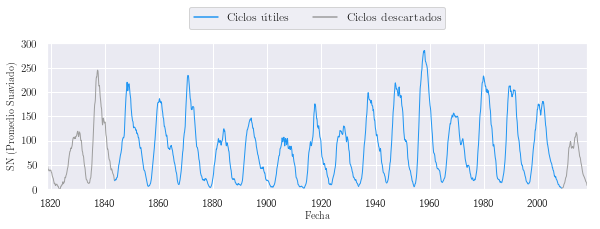

In [30]:
headers = sorted(list(solar_cycles.columns.levels[0].values))
deleted_cycles = []

w_cycles_label = Label(value="Ciclos solares")

w_cycles_selector = SelectMultiple(options=headers, value=headers[:3]+[headers[-1]])
w_cycles_selector.layout.height = '150px'

w_cycles_clean = Button(description='Limpiar seleción de ciclos')
w_cycles_clean.layout.margin = '5px 2px 0'
w_cycles_clean.layout.width = '300px'

w_message = Label(value="Selecione los ciclos que desea eliminar.")
w_message.layout.maxWidth = ''

w_log = HTML(value="Log")
w_log.layout.maxWidth = ''

w_output = Output()

wc_cycles = VBox([w_message, w_cycles_label, w_cycles_selector, w_cycles_clean, w_output])

fig = None


def select_cycles(*args):
    global deleted_cycles
    
    if headers[-1] not in deleted_cycles:
        w_cycles_selector.value = deleted_cycles + [headers[-1]]
    
    deleted_cycles = sorted(list(w_cycles_selector.value))
    
    
def plot_cycles(*args):
    global fig
    global deleted_cycles
    
    deleted_cycles = w_cycles_selector.value
    
    if fig is None:
        fig = plt.figure(figsize=(8.5, 3.5), frameon=False)
    else:
        fig.clf()
    
    axs = fig.add_subplot('111')
        
    for cycle in lcycles:
        if cycle in deleted_cycles or cycle == headers[-1]:
            color = '#9e9e9e'
        else:
            color='#2196f3'
            
        gsmooth, = axs.plot(
            lcycles[cycle]['SN value'],
            color=color,
            linewidth=1
        )
        
    util_cyles = plt.Line2D([], [], color='#2196f3', label=r'$\mathrm{Ciclos\ \acute{u}tiles}$')
    no_util_cyles = plt.Line2D([], [], color='#9e9e9e', label=r'$\mathrm{Ciclos\ descartados}$')

    axs.legend(
        handles=[util_cyles, no_util_cyles],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
        borderaxespad=0.0,
        prop=font_legend)
            
    axs.set_xlim([sn_smooth.index[0], sn_smooth.index[-1]])
    axs.set_xlabel(r'$\mathrm{Fecha}$', fontproperties=font_ticks)
    axs.set_ylim([0, np.ceil(np.nanmax(sn_smooth['SN value'].values)/100.0)*100])
    axs.set_ylabel(r'$\mathrm{SN\ (Promedio\ Suaviado)}$', fontproperties=font_ticks)
    fig.tight_layout()
    plt.show()
    
    
def clean_cycles(*args):
    w_cycles_selector.value = headers[:3]

    
def delete_cycles(*args):
    global deleted_cycles
    
    deleted_cycles = w_cycles_selector.value
    w_cycles_delete.button_style = 'success'
    
w_cycles_selector.observe(select_cycles, 'value')
w_cycles_selector.observe(plot_cycles, 'value')

w_cycles_clean.on_click(clean_cycles)

wc_cycles.on_displayed(plot_cycles)

display(wc_cycles)

#### Ordenamiento de ciclos selecionados

In [31]:
selected_cycles = solar_cycles.copy()

for cycle in deleted_cycles:
    selected_cycles.drop(cycle, 1, inplace=True)

preserved_cycles = list(set(selected_cycles.columns.labels[0].values()))
preserved_cycles = selected_cycles.columns.levels[0].values[preserved_cycles]

# for cycle in preserved_cycles:
selected_cycles.drop(columns=['SN value', 'SN error'], level=1, inplace=True)
selected_cycles.columns = preserved_cycles
selected_cycles

,Cycle 9,Cycle 10,Cycle 11,Cycle 12,Cycle 13,Cycle 14,Cycle 15,Cycle 16,Cycle 17,Cycle 18,Cycle 19,Cycle 20,Cycle 21,Cycle 22,Cycle 23
0,17.61+/-0.31,6.00+/-0.15,9.87+/-0.19,3.75+/-0.14,8.28+/-0.18,4.47+/-0.13,2.44+/-0.12,9.36+/-0.16,5.79+/-0.14,12.88+/-0.17,5.10+/-0.08,14.24+/-0.13,17.79+/-0.15,13.52+/-0.17,11.17+/-0.16
1,18.12+/-0.31,6.33+/-0.16,10.02+/-0.19,4.15+/-0.15,9.65+/-0.19,4.57+/-0.13,2.47+/-0.12,9.51+/-0.16,5.97+/-0.14,12.99+/-0.18,5.47+/-0.08,14.97+/-0.13,18.45+/-0.15,14.65+/-0.17,11.59+/-0.16
2,19.26+/-0.32,6.89+/-0.16,10.00+/-0.19,5.41+/-0.16,10.94+/-0.20,5.15+/-0.14,2.64+/-0.12,9.77+/-0.16,7.70+/-0.15,13.91+/-0.18,6.23+/-0.09,16.22+/-0.14,18.29+/-0.15,16.59+/-0.17,11.31+/-0.16
3,20.41+/-0.33,7.47+/-0.17,11.92+/-0.21,6.21+/-0.17,11.67+/-0.21,6.51+/-0.14,3.96+/-0.13,11.35+/-0.17,8.95+/-0.16,14.58+/-0.19,7.92+/-0.10,17.15+/-0.14,17.90+/-0.15,18.31+/-0.17,11.20+/-0.16
4,20.53+/-0.33,7.41+/-0.16,14.87+/-0.24,7.03+/-0.17,12.31+/-0.21,7.83+/-0.15,5.47+/-0.14,13.60+/-0.18,9.50+/-0.16,15.28+/-0.19,10.51+/-0.11,17.65+/-0.15,18.85+/-0.15,19.90+/-0.18,11.32+/-0.16
5,19.39+/-0.33,7.29+/-0.16,16.99+/-0.25,8.43+/-0.18,14.38+/-0.23,8.35+/-0.16,6.63+/-0.15,16.34+/-0.20,10.50+/-0.17,16.98+/-0.20,11.36+/-0.12,18.36+/-0.15,20.46+/-0.16,22.32+/-0.18,11.97+/-0.16
6,19.72+/-0.33,7.90+/-0.17,19.14+/-0.26,9.53+/-0.20,16.24+/-0.24,8.62+/-0.16,7.68+/-0.15,19.35+/-0.21,10.99+/-0.17,18.85+/-0.21,11.58+/-0.12,19.92+/-0.16,20.81+/-0.16,25.46+/-0.18,13.39+/-0.16
7,21.36+/-0.34,9.28+/-0.19,22.39+/-0.28,11.60+/-0.21,17.92+/-0.25,9.99+/-0.16,8.46+/-0.16,21.48+/-0.22,11.11+/-0.17,20.44+/-0.21,13.83+/-0.13,21.24+/-0.16,19.69+/-0.15,27.97+/-0.18,14.31+/-0.16
8,22.40+/-0.35,10.52+/-0.20,26.16+/-0.30,15.06+/-0.23,21.75+/-0.27,11.25+/-0.17,9.78+/-0.16,23.27+/-0.23,11.86+/-0.17,23.38+/-0.23,17.36+/-0.14,21.83+/-0.16,19.71+/-0.15,30.34+/-0.19,14.53+/-0.16
9,23.7+/-0.4,11.11+/-0.21,29.83+/-0.32,18.25+/-0.26,27.54+/-0.30,13.14+/-0.18,10.94+/-0.17,25.10+/-0.24,13.47+/-0.18,27.54+/-0.24,20.52+/-0.16,22.57+/-0.16,21.61+/-0.16,32.70+/-0.19,15.24+/-0.16


#### Separacion de ciclo en curso

In [32]:
current_cycle = solar_cycles['Cycle 24'].drop(['SN value', 'SN error'], axis=1)
current_cycle.columns = ['Current Cycle']
current_cycle

,Current Cycle
0,2.25+/-0.11
1,2.50+/-0.12
2,2.69+/-0.12
3,2.92+/-0.12
4,3.32+/-0.12
5,3.47+/-0.12
6,4.12+/-0.12
7,5.51+/-0.13
8,7.41+/-0.13
9,9.52+/-0.14


#### Cálculo del ciclo promedio

In [33]:
average_cycle = np.nanmean(selected_cycles.values, 1)
average_cycle = pd.DataFrame(data=average_cycle, columns=['Average Cycle'])
average_cycle

,Average Cycle
0,9.49+/-0.04
1,9.93+/-0.04
2,10.69+/-0.04
3,11.70+/-0.05
4,12.80+/-0.05
5,13.98+/-0.05
6,15.28+/-0.05
7,16.74+/-0.05
8,18.61+/-0.06
9,20.88+/-0.06


#### Grafico del ciclo promedio y su comparación con otros ciclos solares

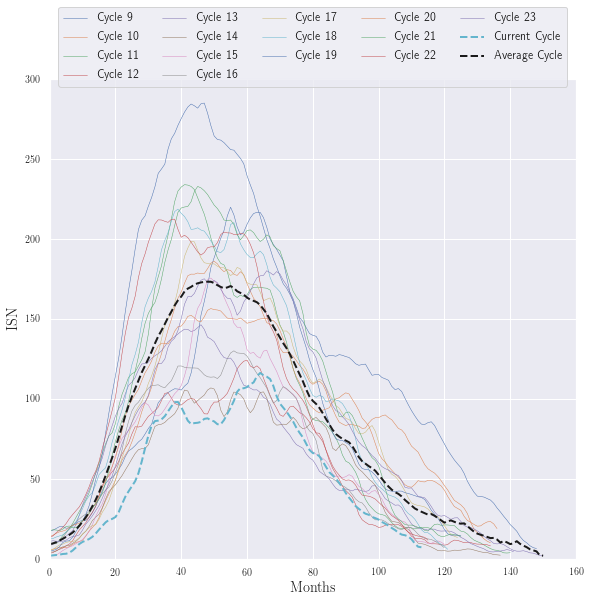

In [34]:
fig = plt.figure(figsize=(8.5, 8.5), frameon=False, facecolor="#ffffff")
axs = fig.add_subplot(1,1,1)

title = r"$\mathrm{Registro\ diario\ del\ N\acute{u}mero\ Manchas\ Solares}$"

for cycle in selected_cycles.columns:
    axs.plot(
        unp.nominal_values(selected_cycles[cycle].values),
        linewidth=0.5,
        antialiased=True, 
        label=cycle)

axs.plot(
    unp.nominal_values(current_cycle.values),
    color='c',
    linewidth=2,
    linestyle='--',
    antialiased=True,
    label="Current Cycle")

axs.plot(
    unp.nominal_values(average_cycle.values),
    color='k',
    linewidth=2,
    linestyle='--',
    antialiased=True,
    label="Average Cycle")

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.nanmax(unp.nominal_values(selected_cycles.values)) / 100.0) * 100

d_yticks = 50
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = 0
x_limu = np.ceil(np.nanmax(selected_cycles.index) / 20.0) * 20

d_xticks = 20
n_xticks = int(np.ceil((x_limu - x_liml) / d_xticks))
t_xticks = [x_liml + i * d_xticks for i in range(n_xticks + 1)]
l_xticks = [r"${0:>3}$".format(x) for x in t_xticks]

x_label = r"$\mathrm{Months}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend settings
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=5,
    borderaxespad=0.0,
    prop=font_legend)

# Display
fig.tight_layout()
plt.show()

### Cálculo de los coeficientes de regresión

Los coeficientes de regresion se calculan mediante la fromula

$$
\mathcal{k}_{n} = \frac{\displaystyle\sum_{c=m}^{M} \Delta\mathcal{R}_{n,c}\Delta\mathcal{R}_{n+1,c}}{\displaystyle\sum_{c=m}^{M} \Delta\mathcal{R}_{n,c}^{2}}
$$

In [35]:
def usum(x):
    xshape = x.shape
    xsum = np.full(xshape[0], unc.ufloat(np.nan, np.nan), dtype='object')
    
    for i in range(xshape[0]):
        row = x[i, :]
        test = unp.nominal_values(row)
        
        if all(np.isnan(test)):
            xsum[i] = unc.ufloat(np.nan, np.nan)
            
        elif any(np.isnan(test)):
            xsum[i] = np.sum(row[np.isfinite(test)])
            
        else:
            xsum[i] = np.sum(row)
            
    return xsum

In [36]:
def regression_coefficients(selected_cycles, average_cycle):
    numerator = (selected_cycles.values.transpose() - np.squeeze(average_cycle.values)).transpose()
    shape = numerator.shape
    numerator = numerator.tolist()
    numerator.append([unc.ufloat(np.nan, np.nan) for i in range(shape[1])])
    numerator = np.array(numerator, dtype='object')
    numerator = numerator[:shape[0], :]*numerator[1:, :]
    numerator = usum(numerator)

    denominator = (selected_cycles.values.transpose() - np.squeeze(average_cycle.values)).transpose()
    denominator = denominator**2
    denominator = usum(denominator)

    coeffs = numerator[:-2]*(denominator[:-2]**-1)
    coeffs = coeffs.tolist()
    coeffs += [unc.ufloat(0,0), unc.ufloat(0,0)]
    coeffs = pd.DataFrame(data=coeffs, columns=['K'])
    return coeffs

In [37]:
coeffs = regression_coefficients(selected_cycles, average_cycle)
coeffs

,K
0,1.0311+/-0.0034
1,1.0039+/-0.0033
2,0.9621+/-0.0033
3,0.966+/-0.004
4,1.019+/-0.005
5,1.088+/-0.004
6,1.0307+/-0.0033
7,1.036+/-0.004
8,1.097+/-0.004
9,1.1114+/-0.0035


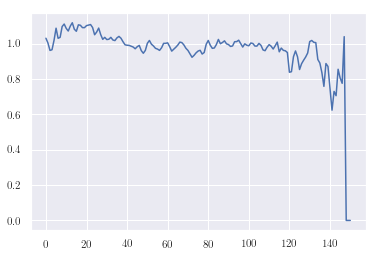

In [38]:
plt.plot(unp.nominal_values(coeffs.values))
plt.show()

### Prediccion de la actividad solar

Una vez obtenidos los coeficientes de regresión, la predicción se realiza mendiante la fórmula

$$
\mathcal{R'}_{n+1} = \tilde{\mathcal{R}}_{n+1} + \mathcal{k}_{n}\Delta\mathcal{R}_{n}
$$

In [39]:
cycle_prediction = current_cycle.copy()
cycle_prediction = np.squeeze(cycle_prediction.values)
average_deviation = cycle_prediction - np.squeeze(average_cycle.values)
average_deviation = average_deviation*np.squeeze(coeffs.values)

start, = np.where(np.isnan(unp.nominal_values(np.squeeze(current_cycle.values))))
start = start[0]
offset = 20

for i in range(start, start+offset):
        cycle_prediction[i] = np.squeeze(average_cycle.values)[i] + average_deviation[i-1]
        average_deviation[i] = cycle_prediction[i] - np.squeeze(average_cycle.values)[i]
        average_deviation[i] = average_deviation[i]*np.squeeze(coeffs.values)[i]
        
cycle_prediction[:start] = unc.ufloat(np.nan,np.nan)

### Comparación de los resultados obtenidos

#### Resultados obtenidos

In [40]:
scale_std = 25

softb_t = pd.date_range(start=lcycles['Cycle 24'].index[0], end='1/1/2030')
softb_t = softb_t[softb_t.day==1]
softb_t = softb_t[start:start+offset]

softb_d = list(
    zip(
        unp.nominal_values(cycle_prediction)[start:start+offset], 
        (unp.nominal_values(cycle_prediction)+scale_std*unp.std_devs(cycle_prediction))[start:start+offset],
        (unp.nominal_values(cycle_prediction)-scale_std*unp.std_devs(cycle_prediction))[start:start+offset],
    )
)

softb = pd.DataFrame(data=softb_d, index=softb_t, columns=['Forecast', 'Max', 'Min'])
softb

,Forecast,Max,Min
2018-06-01,6.897040,8.703885,5.090196
2018-07-01,5.759975,7.857053,3.662898
2018-08-01,7.138549,9.489222,4.787877
2018-09-01,6.595706,9.079396,4.112015
2018-10-01,5.959214,8.546146,3.372282
2018-11-01,5.282210,7.931232,2.633187
2018-12-01,4.817768,7.487913,2.147623
2019-01-01,8.646218,11.291646,6.000789
2019-02-01,11.508154,14.188828,8.827479
2019-03-01,11.614983,14.274139,8.955827


#### Predicción de NOAA

Estos datos fueron obtenidos directamente del servicio FTP de NOAA

* ftp://ftp.swpc.noaa.gov/pub/weekly/Predict.txt

In [41]:
noaa_t = [
    pd.Timestamp("2018-05-01"), 
    pd.Timestamp("2018-06-01"), 
    pd.Timestamp("2018-07-01"), 
    pd.Timestamp("2018-08-01"), 
    pd.Timestamp("2018-09-01"), 
    pd.Timestamp("2018-10-01"), 
    pd.Timestamp("2018-11-01"), 
    pd.Timestamp("2018-12-01"), 
    pd.Timestamp("2019-01-01"), 
    pd.Timestamp("2019-02-01"), 
    pd.Timestamp("2019-03-01"), 
    pd.Timestamp("2019-04-01"), 
    pd.Timestamp("2019-05-01"), 
    pd.Timestamp("2019-06-01"), 
    pd.Timestamp("2019-07-01"), 
    pd.Timestamp("2019-08-01"), 
    pd.Timestamp("2019-09-01"), 
    pd.Timestamp("2019-10-01"), 
    pd.Timestamp("2019-11-01"), 
    pd.Timestamp("2019-12-01"), 
]

noaa_d = [
    [4.8,  5.8, 3.8],
    [5.3,  7.3, 3.3],
    [5.6,  8.6, 2.6],
    [5.9, 10.9, 0.9],
    [6.3, 11.3, 1.3],
    [6.6, 12.6, 0.6],
    [6.7, 13.7, 0.0],
    [6.5, 13.5, 0.0],
    [6.6, 14.6, 0.0],
    [6.8, 15.8, 0.0],
    [6.9, 15.9, 0.0],
    [7.1, 17.1, 0.0],
    [7.0, 17.0, 0.0],
    [6.4, 16.4, 0.0],
    [5.9, 15.9, 0.0],
    [5.5, 15.5, 0.0],
    [5.1, 15.1, 0.0],
    [4.8, 14.8, 0.0],
    [4.4, 14.4, 0.0],
    [4.1, 14.1, 0.0],   
]
noaa = pd.DataFrame(data=noaa_d, index=noaa_t, columns=['Forecast', 'Max', 'Min'])
noaa

,Forecast,Max,Min
2018-05-01,4.8,5.8,3.8
2018-06-01,5.3,7.3,3.3
2018-07-01,5.6,8.6,2.6
2018-08-01,5.9,10.9,0.9
2018-09-01,6.3,11.3,1.3
2018-10-01,6.6,12.6,0.6
2018-11-01,6.7,13.7,0.0
2018-12-01,6.5,13.5,0.0
2019-01-01,6.6,14.6,0.0
2019-02-01,6.8,15.8,0.0


#### Predicción de SILSO

Estos datos fueron obtenidos directamente del servicio web de SILSO

* http://sidc.oma.be/silso/FORECASTS/prediML.txt

In [42]:
silso_t = [
    pd.Timestamp("2018-05-01"),
    pd.Timestamp("2018-06-01"),
    pd.Timestamp("2018-07-01"),
    pd.Timestamp("2018-08-01"),
    pd.Timestamp("2018-09-01"),
    pd.Timestamp("2018-10-01"),
    pd.Timestamp("2018-11-01"),
    pd.Timestamp("2018-12-01"),
    pd.Timestamp("2019-01-01"),
    pd.Timestamp("2019-02-01"),
    pd.Timestamp("2019-03-01"),
    pd.Timestamp("2019-04-01"),
    pd.Timestamp("2019-05-01"),
    pd.Timestamp("2019-06-01"),
    pd.Timestamp("2019-07-01"),
    pd.Timestamp("2019-08-01"),
    pd.Timestamp("2019-09-01"),
    pd.Timestamp("2019-10-01"),   
]

silso_d = [
    [ 7.3,   2.5],
    [ 6.4,   4.8],
    [ 5.2,   6.3],
    [ 4.8,   7.5],
    [ 4.7,   8.1],
    [ 4.5,   8.5],
    [ 4.2,   9.1],
    [ 4.2,  10.0],
    [ 4.3,  10.8],
    [ 4.9,  11.4],
    [ 5.8,  11.1],
    [ 6.2,  10.5],
    [ 6.7,  10.3],
    [ 8.0,  10.4],
    [ 9.7,  10.8],
    [10.9,  12.2],
    [12.3,  14.3],
    [14.0,  16.7],
]
silso_d = np.array(silso_d)
silso_d = np.array(list(zip(silso_d[:,0], silso_d[:,0] + silso_d[:,1], silso_d[:,0] - silso_d[:,1])))
silso = pd.DataFrame(data=silso_d, index=silso_t, columns=['Forecast', 'Max', 'Min'])
silso

,Forecast,Max,Min
2018-05-01,7.3,9.8,4.8
2018-06-01,6.4,11.2,1.6
2018-07-01,5.2,11.5,-1.1
2018-08-01,4.8,12.3,-2.7
2018-09-01,4.7,12.8,-3.4
2018-10-01,4.5,13.0,-4.0
2018-11-01,4.2,13.3,-4.9
2018-12-01,4.2,14.2,-5.8
2019-01-01,4.3,15.1,-6.5
2019-02-01,4.9,16.3,-6.5


#### Comparación de resultados

##### **Comparacion con los resultados de NOAA**

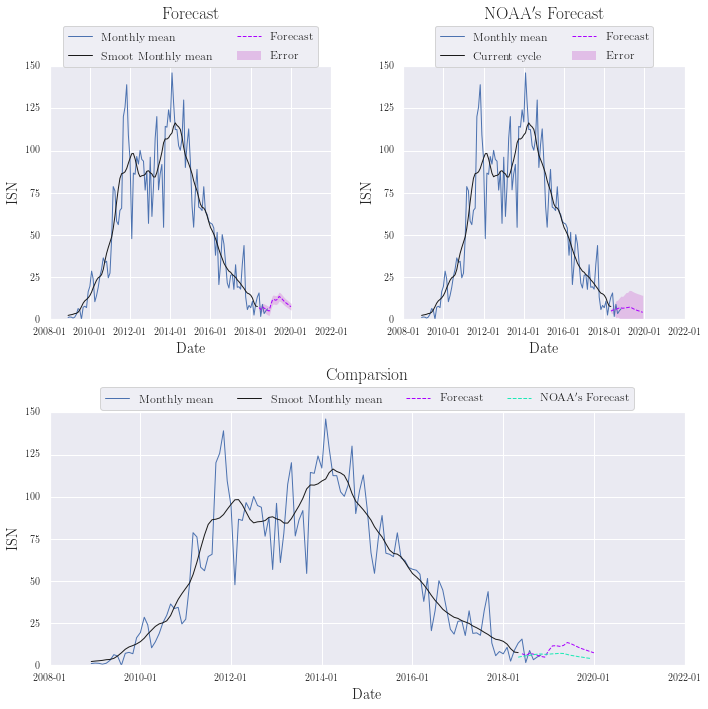

In [85]:
fig = plt.figure(figsize=(10, 10), frameon=False, facecolor="#ffffff")
index = lcycles['Cycle 24']['SN value'].index

# Resultados
axs = fig.add_subplot(2,2,1)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Smoot\ Monthly\ mean}$"
)

axs.plot(
    softb.index,
    softb['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

plt.fill_between(
    softb.index,
    softb['Min'].values, 
    softb['Max'].values, 
    facecolor="#e1bee7",
    antialiased=True,
    linewidth=0,
    label=r"$\mathrm{Error}$"
)

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{Forecast}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.16])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.16),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)


# Resultados NOAA
axs = fig.add_subplot(2,2,2)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Current\ cycle}$"
)
    
axs.plot(
    noaa.index,
    noaa['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

plt.fill_between(
    noaa.index,
    noaa['Min'].values, 
    noaa['Max'].values, 
    facecolor="#e1bee7",
    antialiased=True,
    linewidth=0,
    label=r"$\mathrm{Error}$"
)

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{NOAA's\ Forecast}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.16])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.16),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)

# Comparacion
axs = fig.add_subplot(2,1,2)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Smoot\ Monthly\ mean}$"
)

axs.plot(
    softb.index,
    softb['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

axs.plot(
    noaa.index,
    noaa['Forecast'].values, 
    color="#1de9b6",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{NOAA's\ Forecast}$"
)


# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{Comparsion}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.10])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=4,
    borderaxespad=0.0,
    prop=font_legend)

# Display
fig.tight_layout()
plt.show()
fig.savefig("NOAA comparsion.pdf", dpi=300, facecolor='w', edgecolor='w', orientation='portrait')

##### **Comparacion con los resultados de SILSO**

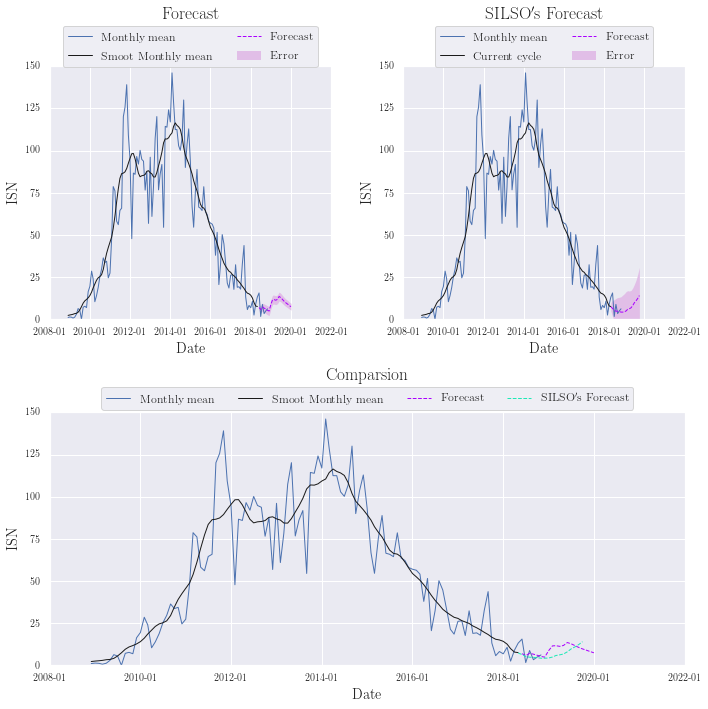

In [86]:
fig = plt.figure(figsize=(10, 10), frameon=False, facecolor="#ffffff")
index = lcycles['Cycle 24']['SN value'].index

# Resultados
axs = fig.add_subplot(2,2,1)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Smoot\ Monthly\ mean}$"
)

axs.plot(
    softb.index,
    softb['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

plt.fill_between(
    softb.index,
    softb['Min'].values, 
    softb['Max'].values, 
    facecolor="#e1bee7",
    antialiased=True,
    linewidth=0,
    label=r"$\mathrm{Error}$"
)

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{Forecast}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.16])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.16),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)


# Resultados SILSO
axs = fig.add_subplot(2,2,2)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Current\ cycle}$"
)
    
axs.plot(
    silso.index,
    silso['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

plt.fill_between(
    silso.index,
    silso['Min'].values, 
    silso['Max'].values, 
    facecolor="#e1bee7",
    antialiased=True,
    linewidth=0,
    label=r"$\mathrm{Error}$"
)

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{SILSO's\ Forecast}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.16])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.16),
    ncol=2,
    borderaxespad=0.0,
    prop=font_legend)

# Comparacion
axs = fig.add_subplot(2,1,2)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Smoot\ Monthly\ mean}$"
)

axs.plot(
    softb.index,
    softb['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

axs.plot(
    silso.index,
    silso['Forecast'].values, 
    color="#1de9b6",
    linestyle='--',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{SILSO's\ Forecast}$"
)


# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 2
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{Comparsion}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.10])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=4,
    borderaxespad=0.0,
    prop=font_legend)

# Display
fig.tight_layout()
plt.show()
fig.savefig("SILSO comparsion.pdf", dpi=300, facecolor='w', edgecolor='w', orientation='portrait')

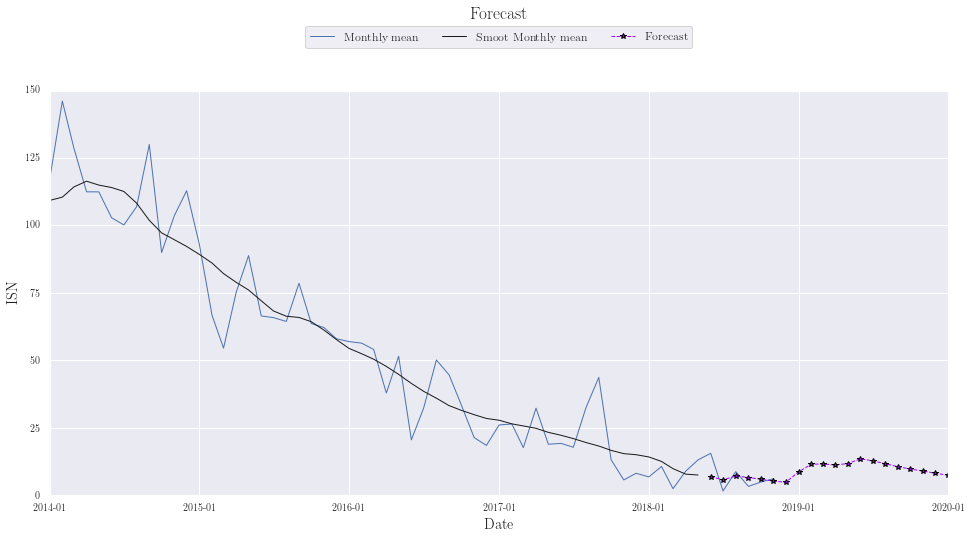

In [84]:
fig = plt.figure(figsize=(13.66, 7.68), frameon=False, facecolor="#ffffff")
index = lcycles['Cycle 24']['SN value'].index

# Resultados
axs = fig.add_subplot(1,1,1)

axs.plot(
    sn_monthly['SN value'][index[0]:],
    color='b',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Monthly\ mean}$"
)

axs.plot(
    lcycles['Cycle 24']['SN value'],
    color='k',
    linestyle='-',
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Smoot\ Monthly\ mean}$"
)

axs.plot(
    softb.index,
    softb['Forecast'].values, 
    color="#aa00ff",
    linestyle='--',
    marker='*',
    markeredgecolor="#000000",
    markeredgewidth=1,
    antialiased=True,
    linewidth=1,
    label=r"$\mathrm{Forecast}$"
)

# Y axis settings
y_liml = 0
y_limu = np.ceil(np.max(sn_monthly['SN value'][index[0]:index[-1]].values) / 25.0) * 25

d_yticks = 25
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

axs.set_ylim([y_liml, y_limu])
axs.set_yticks(t_yticks)
axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
axs.set_ylabel(y_label, fontproperties=font_label)

# X axis settings
x_liml = pd.Timestamp(f"2014-01-01") # lcycles['Cycle 24'].index[0]
x_limu = pd.Timestamp(f"2020-01-01") # pd.Timestamp(f"{softb.index[-1].year+1}-01-01")

d_xticks = 1
n_xticks = int(np.ceil((x_limu.year - x_liml.year) / d_xticks))
t_xticks = [pd.Timestamp(x_liml.year + i * d_xticks, 1, 1) for i in range(n_xticks + 1)]
l_xticks = [r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks]

x_label = r"$\mathrm{Date}$"

axs.set_xlim([x_liml, x_limu])
axs.set_xticks(t_xticks)
axs.set_xticklabels(l_xticks, fontproperties=font_ticks)
axs.set_xlabel(x_label, fontproperties=font_label)

# Legend and title settings
axs.set_title(r"$\mathrm{Forecast}$", fontproperties=font_title)
axs.title.set_position([0.5, 1.16])  
axs.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.16),
    ncol=3,
    borderaxespad=0.0,
    prop=font_legend)

# Display
fig.tight_layout()
plt.show()
fig.savefig("Firecast.png", dpi=600, facecolor='w', edgecolor='w', orientation='portrait')

In [83]:
print(softb.to_csv('forecast.csv', columns=['Forecast'], header=['SSN'],index_label='Fecha',date_format='%Y-%m',float_format='%6.2f'))

None
